# $\mathrm{RESOLVE \space UNIT \space \beta}$
## 周波数領域電磁探査法(RESOLVE)データの深層学習を用いた水平多層構造解析
入力セルを編集後、全てのセルを実行してください。

## 各種ライブラリのインポート

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys, os
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from dlxem import emexecutor as em
from dlxem import networks, forward

## 入力セル

In [28]:
# ニューラルネットワークの名前
dnn_name = 'albion_b210811'

"""
層厚の設定
　学習データの生成から地下構造の内、層数と層厚は固定されます。
　入力値は層数、表層の厚さ、最終層の上端深度、層厚の等分割スケールの４つです。
　全n層の内、表層と最終層の間は線形スケールまたは対数スケールで(n-2)等分されます。
　一層ずつ手入力で決めることもできます。
"""
# 層数
nlayer = 30

# 表層の厚さ
init_thick = 0.5

# 最終層の上端深度
last_depth = 150

# 層厚のスケール
split_scale = 'log'

# 層厚の手入力 on : manual_input = True / off : manual_input = False
manual_input = False

# 層厚 e.g.) thicks = [100, 10, 100]
thicks = None



"""
人口学習データの生成に関する設定
"""
# 学習に用いる比抵抗構造-磁場応答データの数
size = 20000

# 生成する比抵抗の平均値 (Ohm-m)
res_mean = 100

# RESOLVEの測定周波数(昇順, Hz)
freqs = [382, 1822, 7970, 35920, 130100]

# バード高さの下限 (m)
height_min = 10

# バード高さの上限 (m)
height_max = 100

# コイル間のオフセット (m)
offset = 7.86

# ノイズの付与　on : = True, off : = False
add_noise = True

# ノイズレベル（付与するノイズの標準偏差, ppm)
noise_level = [10, 10, 20, 40, 50]

# 比抵抗構造生成モード 現状、'normal'で固定
generate_mode = 'normal'


"""
ニューラルネットワークの学習に関する設定
　★おすすめ設定その１ (精度重視)
    batch_size = size / 50
    epochs = 200 ~ 300
　★おすすめ設定その２（時短重視）
    batch_size = size / 100 
    epochs = 100
"""
# バッチサイズ　値が大きいほど学習時間は短くなります。
batch_size = 100
# エポック回数 値が小さいほど学習時間が短くなります。
epochs = 100


"""
深層学習解析を適用するフィールドデータの入力
"""
# 探査プロジェクト名（自由）
field_name = 'bookpurnong'

# データは表形式
# CSV / XYZ(TXT) から選べる
datafile_format = 'XYZ'

# データファイルのパス
data_directory = "database/survey/bookpurnong/Bookpurnong_Resolve_Exported.XYZ"

# TXTの場合の冒頭スキップ行数
skiprows = 8

# 使用するデータ列の列番号
#  測線番号, Easting (m), Northing (m), 地表面標高 (m), HCP5種同相成分 (ppm), HCP5種離層成分 (ppm), バード高さ
#  ※ 同相成分、離相成分は周波数の昇順にします。
pickup_columns = [29, 9, 10, 12, 17, 19, 23, 25, 27, 18, 20, 24, 26, 28, 13]

# 測定データファイルの欠損値記号
nan_char = '*'

# 保存先のパス、ファイル名
# database/result/~.csv
save_path = "database/result/{}_result_by_{}.csv".format(field_name, dnn_name)

## 1. 層構造の決定

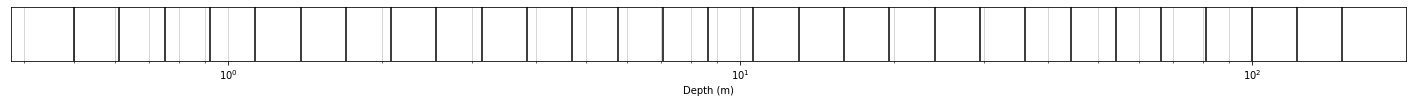

層境界深度
0.0 m | 0.5 m | 0.613 m | 0.751 m | 0.921 m | 1.129 m | 1.385 m | 1.697 m | 2.081 m | 2.551 m | 3.127 m | 3.834 m | 4.7 m | 5.762 m | 7.064 m | 8.66 m | 10.617 m | 13.016 m | 15.956 m | 19.562 m | 23.981 m | 29.4 m | 36.042 m | 44.185 m | 54.169 m | 66.407 m | 81.411 m | 99.805 m | 122.355 m | 150.0 m | 

In [29]:
if manual_input:
    thicks = np.array(thicks)
    depth = [0]
    for t in thicks:
        depth.append(depth[-1] + t)
    depth = np.array(depth)
    print('層境界深度')
    for i in depth:
        print(round(i, 3) ,end=' m | ')

else:
    sys.path.append('../../')
    from dlxem.tools import thicks_maker
    thicks, depth = thicks_maker(init_thick, last_depth, nlayer, split_scale)
    plt.show()
    print('層境界深度')
    for i in depth:
        print(round(i, 3) ,end=' m | ')

## 2. データ生成

In [30]:

config = {
    'thicks' : thicks,
    'rmean' : np.log10(res_mean),
    'rscat' : 1.0,
    'height_range' : (height_min, height_max),
    'freqs' : freqs,
    'span' : offset,
    'add_noise' : add_noise,
    'noise_level' : noise_level,
    'random_mode' : generate_mode
}

In [31]:

parallel_num = 10

dataset_dir = 'database/dataset/'
dsetfile_path = dataset_dir + dnn_name + '_{}_{}.csv'.format(nlayer, size)

model_dir = 'model/'
histfile_path = model_dir + 'history/' + dnn_name + 'history.csv'
nnetfile_path = model_dir + 'network/' + dnn_name + 'network.h5'


if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    print("-> /" + dsetfile_path)


Datasets already exist


## 3. ニューラルネットワークの学習

In [32]:
#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()

#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [33]:
if os.path.exists(nnetfile_path):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


The Specified Neural Network Model Already Exists.


## 4. 評価・テスト

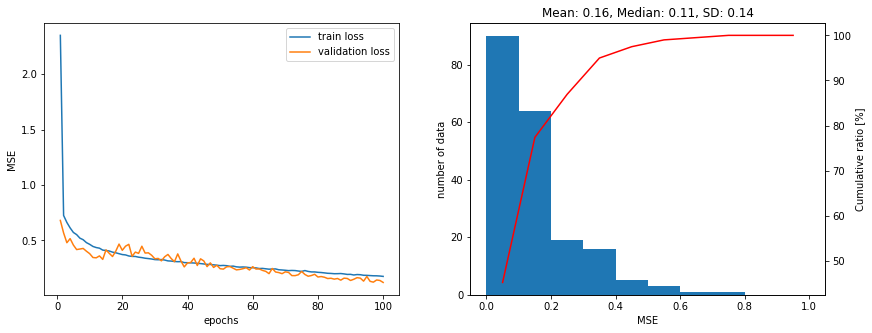

In [34]:
epochx = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1.plot(epochx, loss, label='train loss')
ax1.plot(epochx, val_mse, label='validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('MSE')
ax1.legend()

terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

ax2 = fig.add_subplot(122)
max_mse = res_mse.max()
nbins = int(max_mse // 0.1)
bins = [.1*(i) for i in range(nbins)]
n, bins, patches = ax2.hist(res_mse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax2.set_xlabel('MSE')
ax2.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
std = np.std(res_mse)
ax2.set_title('Mean: {mean:.2f}, Median: {median:.2f}, SD: {std:.2f}'.format(mean=mean, median=median, std=std))

# 第2軸のプロット
bx2 = ax2.twinx()
lines = bx2.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx2.set_ylabel('Cumulative ratio [%]');

182


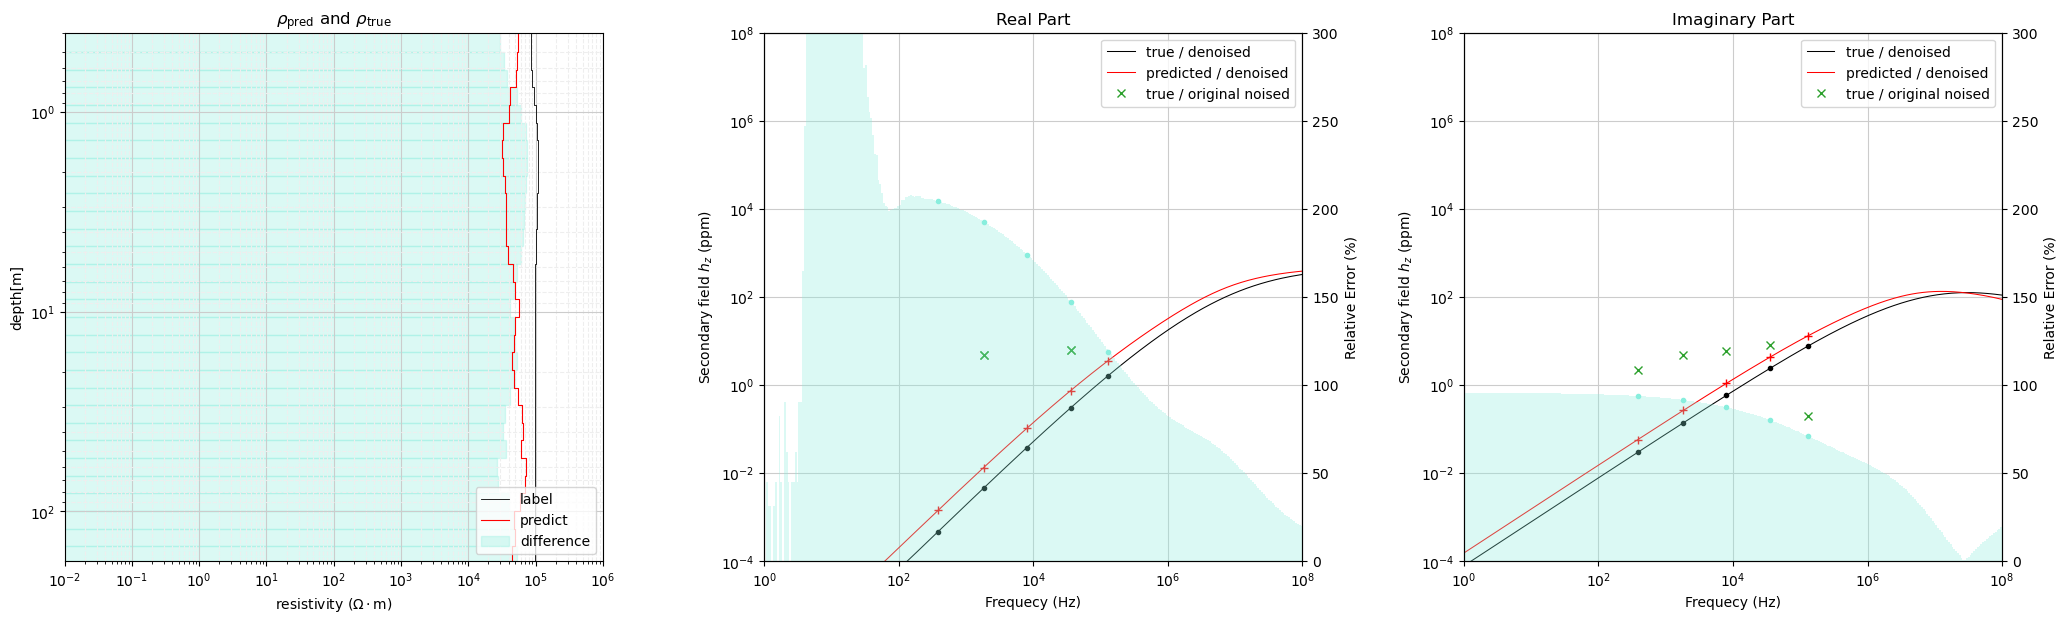

In [35]:
sys.path.append('../../')
from dlxem import myviz as viz

true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size)

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_range = (0, 8)
print(index)

fig = viz.resolve.sumplot(
    thicks, pred_res, true_res, height, offset, freqs, cfreq_range, orig_emf, noised=add_noise, log_depth=True
)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.axes[0].set_yscale('log')

## 5. DL解析

In [36]:
for i in range(len(pickup_columns)):
    pickup_columns[i] -= 1

header = ['line No.', 'easting', 'northing', 'elevation', 'EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
dnnx_index = ['EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
loc_index = ['line No.', 'easting', 'northing', 'elevation']

if os.path.exists(save_path):
    print('preprocessing has already done')
    pass

else:
    if datafile_format == 'XYZ':
        data = np.loadtxt(data_directory, skiprows=skiprows)
        dfd = data[:, pickup_columns]
        df = pd.DataFrame(dfd, columns=header)

    elif datafile_format == 'CSV':
        data = pd.read_csv(data_directory)
        dfd = data.iloc[:, pickup_columns].values
        df = pd.DataFrame(dfd, columns=header)

    # 欠損値を含む行
    df = df.replace(nan_char, np.nan)
    df = df.dropna(how='any')
    x = df[dnnx_index].values
    loc = df[loc_index].values

    stdx = sc.transform(x)
    res = network.predict(stdx)
    res = 10 ** res

    numlayer = len(depth)
    res_header = ['R{}'.format(i+1) for i in range(numlayer)]
    header = [*header, *res_header]
    rdata = np.hstack([loc, x, res])
    rdf = pd.DataFrame(rdata)
    rdf.to_csv(save_path, header=header, index=False)